In [1]:
!pip install keras-tuner -q

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, applications
import kerastuner as kt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\amany\AppData\Local\Temp\ipykernel_22016\365464792.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


DATA


In [3]:
TEST_PATH = "Plant Counting/test/Plant.tfrecord"
TRAIN_PATH = "Plant Counting/train/Plant.tfrecord"
VALID_PATH = "Plant Counting/valid/Plant.tfrecord"
MODEL_PATH = "Plant_counting_model.keras"


In [4]:
BATCH_SIZE = 32
EPOCH = 50

In [5]:
train_length = len(list(tf.data.TFRecordDataset(TRAIN_PATH)))
valid_length = len(list(tf.data.TFRecordDataset(VALID_PATH)))

In [ ]:
def _parse_function(example_proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),  
    }

   
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

   
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    image = tf.image.resize(image, [128, 128])  
    image = image / 255.0  

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)

    
    label_sparse = parsed_features['image/object/class/label']
    label = tf.sparse.to_dense(label_sparse, default_value=-1)  

   
    label = label[0] if tf.shape(label)[0] > 0 else tf.constant(-1, dtype=tf.int64)

    return image, label


In [7]:

def inspect_tfrecord(file_path):
    raw_dataset = tf.data.TFRecordDataset(file_path)
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)


inspect_tfrecord(TRAIN_PATH)

features {
  feature {
    key: "image/width"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/object/class/text"
    value {
      bytes_list {
        value: "cotton plant"
      }
    }
  }
  feature {
    key: "image/object/class/label"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "image/object/bbox/ymin"
    value {
      float_list {
        value: 0
      }
    }
  }
  feature {
    key: "image/object/bbox/ymax"
    value {
      float_list {
        value: 1
      }
    }
  }
  feature {
    key: "image/object/bbox/xmin"
    value {
      float_list {
        value: 0.03125
      }
    }
  }
  feature {
    key: "image/object/bbox/xmax"
    value {
      float_list {
        value: 0.975
      }
    }
  }
  feature {
    key: "image/height"
    value {
      int64_list {
        value: 640
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "j

In [8]:
def return_dataset(path):
    dataSet = tf.data.TFRecordDataset(path).map(_parse_function)
    dataset = dataSet.filter(lambda image, label: tf.size(image) > 0 and label>=0)
    dataset = dataset.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

    return dataset



In [9]:
train = return_dataset(TRAIN_PATH)
test = return_dataset(TEST_PATH)
validate = return_dataset(VALID_PATH)

Model Work
|

In [ ]:
def model_builder(hp):
    model = models.Sequential()


    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3)
    )
    base_model.trainable = False
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

 
    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(units=hp_units, activation='relu'))


    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    model.add(layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [11]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_mae',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='plant_counting_tuning'
)


early_stop = callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss"
)



tuner.search(train, epochs=10, validation_data=validate, callbacks=[early_stop, checkpoint_cb])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train, validation_data=validate, epochs=30, steps_per_epoch=train_length//BATCH_SIZE,validation_steps=valid_length, callbacks=[early_stop, checkpoint_cb])


model.save(MODEL_PATH)

Reloading Tuner from my_dir\plant_counting_tuning\tuner0.json
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - loss: 1.8029 - mae: 0.9119 - val_loss: 0.2209 - val_mae: 0.3756
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0890 - mae: 0.2103 - val_loss: 0.1670 - val_mae: 0.3121
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - loss: 0.0826 - mae: 0.2101 - val_loss: 0.1318 - val_mae: 0.2898
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 0.0775 - mae: 0.2047 - val_loss: 0.1119 - val_mae: 0.2792
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - loss: 0.0676 - mae: 0.1932 - val_loss: 0.1119 - val_mae: 0.2500
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - loss: 0.0687 - mae: 0.1934 - val_loss: 0.1198 - val_mae: 0.2489
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - loss: 0.0642 - mae: 0.1853 - val_loss: 0.0990 - val_mae: 0.2421
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - loss: 0.0671 - mae: 0.1911 - val_loss: 0.1253 - val_mae: 0.2434
Ep

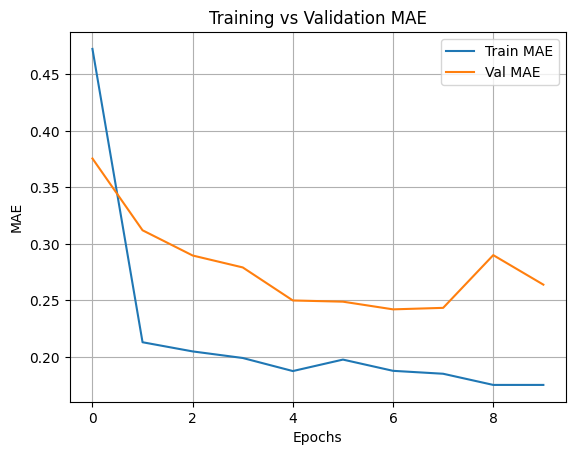

In [12]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training vs Validation MAE')
plt.grid(True)
plt.show()

In [13]:
model = models.load_model("best_model.keras")

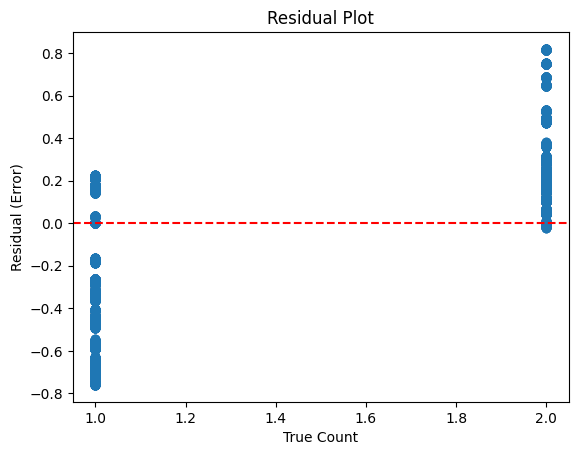

In [15]:
residuals = [t - p for t, p in zip(true_vals, pred_vals)]
plt.scatter(true_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Count")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\Users\amany\AppData\Local\Temp\ipykernel_22016\2584715423.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_count = int(np.round(pred[0]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


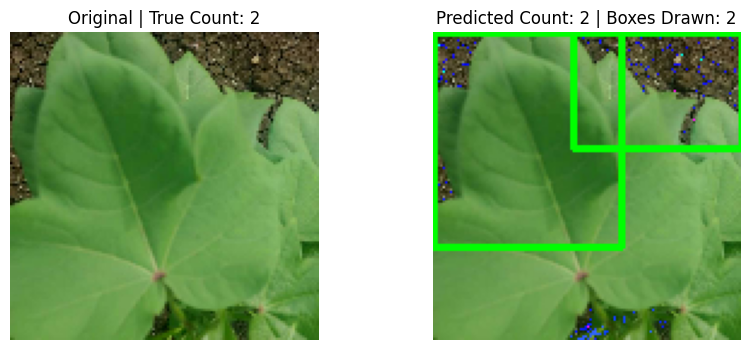

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


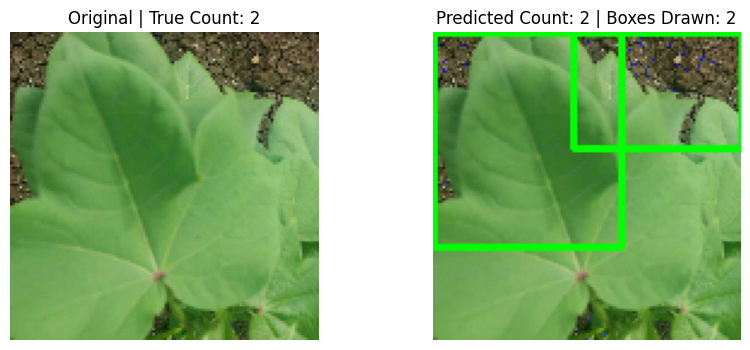

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


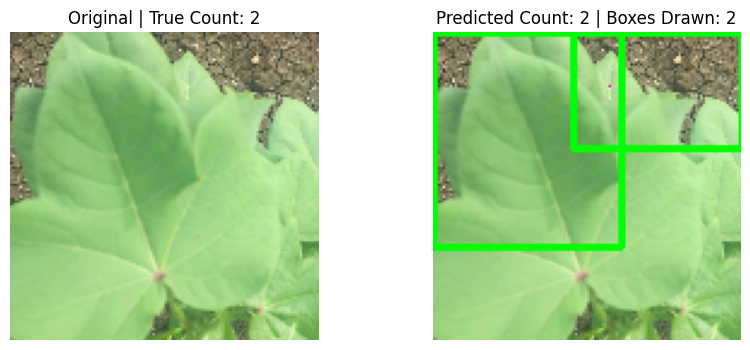

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


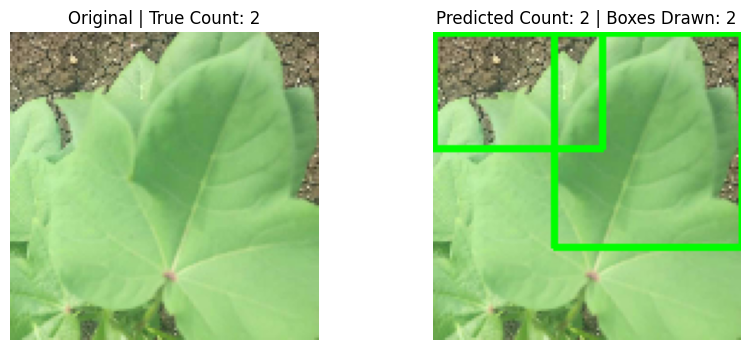

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


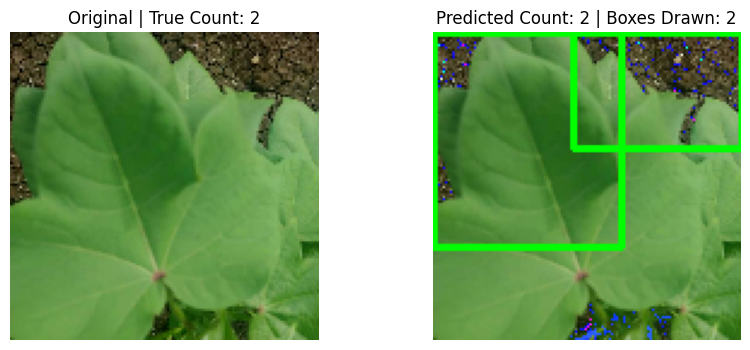

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


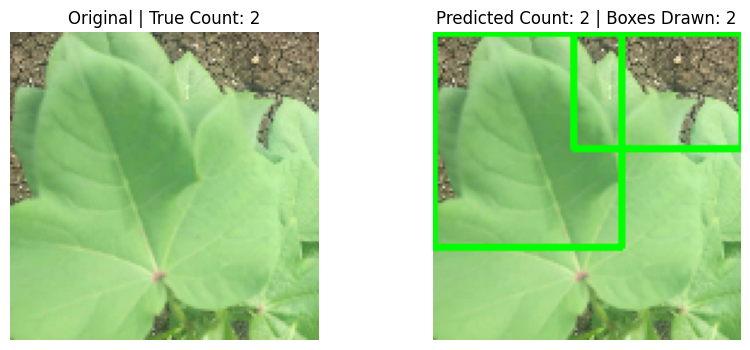

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


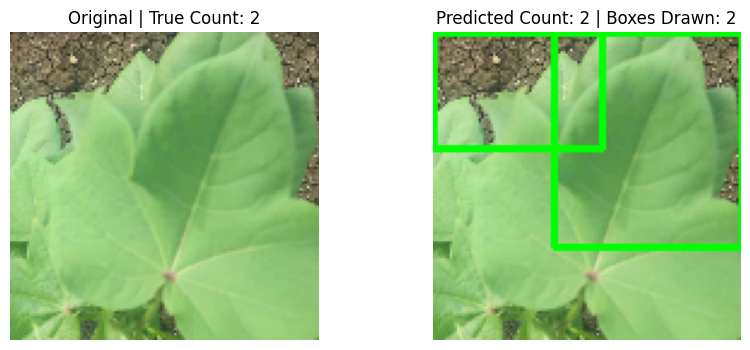

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


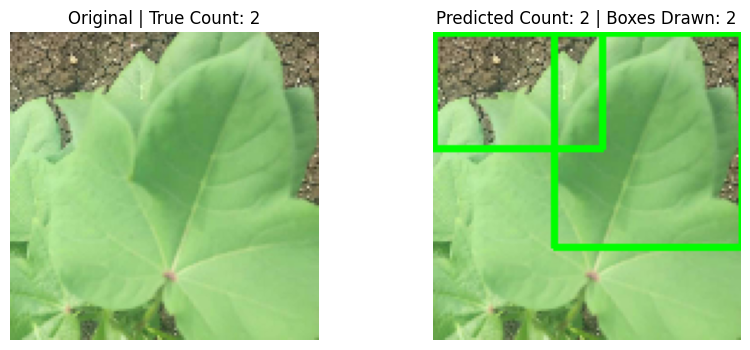

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


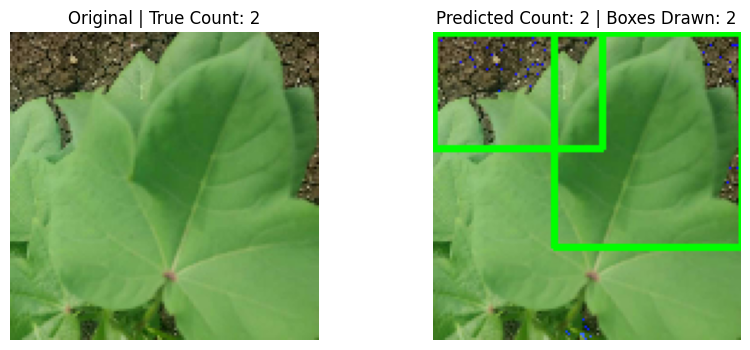

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


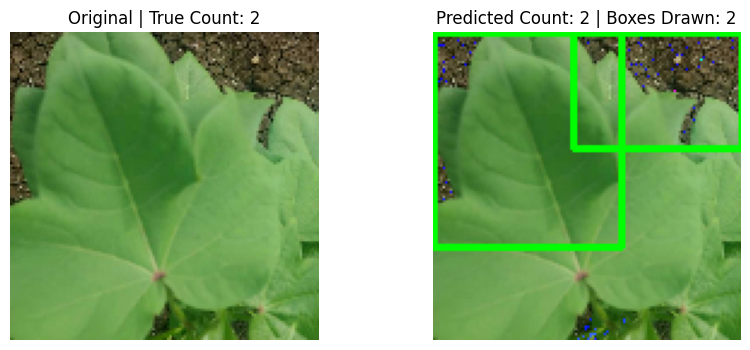

In [16]:


for image_batch, label_batch in test.take(10):
    image = image_batch[0].numpy()
    label = label_batch[0].numpy()


    pred = model.predict(image_batch)
    predicted_count = int(np.round(pred[0]))


    image_uint8 = (image * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2BGR)



    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)


    blur = cv2.GaussianBlur(gray, (5, 5), 0)


    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)


    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    boxed_image = image_bgr.copy()
    count = 0

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h


        if area > 1500:
            count += 1
            cv2.rectangle(boxed_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(boxed_image, f"Plant {count}", (x, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)





    boxed_rgb = cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB)


    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original | True Count: {label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(boxed_rgb)
    plt.title(f"Predicted Count: {predicted_count} | Boxes Drawn: {count}")
    plt.axis("off")

    plt.show()


In [17]:
def evaluate_model(model):
    test_dataset = tf.data.TFRecordDataset(TEST_PATH)
    test_dataset = test_dataset.map(_parse_function)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    
    
    loss, mae = model.evaluate(test_dataset)
    print(f"\nTest Metrics:\nLoss: {loss:.2f} MAE: {mae:.2f}")
    
    # Get predictions for more metrics
    y_true = []
    y_pred = []
    for images, counts in test_dataset:
        y_true.extend(counts.numpy())
        y_pred.extend(model.predict(images).flatten())
        
    
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R^2 Score: {r2_score(y_true, y_pred):.2f}")

In [18]:
evaluate_model(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1753 - mae: 0.3445


c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Test Metrics:
Loss: 0.18 MAE: 0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
RMSE: 0.41
R^2 Score: 0.33


In [ ]:

def predict_single_image(image_path, model):
   
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img.numpy())
    predicted_count = round(prediction[0][0])

    # Convert to NumPy for OpenCV
    img_np = img[0].numpy()
    img_uint8 = (img_np * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    # Draw a rectangle (bounding box) - full image for now
    height, width, _ = image_bgr.shape
    cv2.rectangle(image_bgr, (10, 10), (width - 10, height - 10), (0, 255, 0), 2)
    

    # Display using matplotlib
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prediction : count {predicted_count}")
    plt.show()

    return predicted_count


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


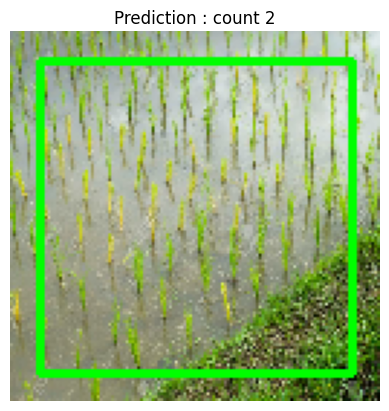

2

In [20]:
predict_single_image("sample.jpg", model)

In [ ]:

def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    label = tf.sparse.to_dense(example['image/object/class/label'])
    return image, tf.reduce_sum(label)  # Count of objects

def load_dataset(tfrecord_path, batch_size=32, shuffle_buffer=1000):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = load_dataset('train.tfrecord')
val_dataset = load_dataset('val.tfrecord')
test_dataset = load_dataset('test.tfrecord', batch_size=1)


In [ ]:

def build_model():
    base_model = applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Fine-tuning later if needed
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)  # Regression output
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mae',
                  metrics=['mae'])
    return model

model = build_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)